In [1]:
import os
import numpy as np
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image,ImageOps
import cv2
import matplotlib.pyplot as plt

In [2]:
#################img_rows, img_cols = 32 , 32 actual
img_rows, img_cols = 128 , 128  # next target 128 128


In [3]:
isolated_train_path= 'D:/CXR8/ChestX-ray'
isolated_test_path= 'D:/CXR8/ChestX-ray Test'

In [4]:
for root, dirnames, filenames in os.walk(isolated_train_path):
    for filename in filenames:
        file_path = os.path.join(root, filename)
        img = Image.open(file_path)
        Grey = img.resize((img_rows, img_cols))
        #img = ImageOps.invert(img)
        #Grey = img.convert('L')
        #ret,thresh1 = cv.threshold(Grey,127,255,cv.THRESH_BINARY)
        #threshold = 105
        #Grey = Grey.point(lambda p: p < threshold and 255)
        #Grey = ImageOps.invert(img)
        Grey = Grey.convert('RGB')
        Grey.save(file_path)

In [5]:
train_data_dir = isolated_train_path
validation_data_dir = isolated_test_path

In [6]:
img_width, img_height, channel = img_rows, img_cols, 3
# batch_size = 20 - actual
batch_size = 128 # 128 diye try kora hoisilo

In [7]:
datagen = ImageDataGenerator(rescale=1./255)

#automatically retrive images and their classes for training and validation
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        shuffle= True,
        class_mode ='categorical')

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        shuffle= False,
        class_mode ='categorical')

Found 10500 images belonging to 15 classes.
Found 2100 images belonging to 15 classes.


In [8]:
IMG_SHAPE = img_cols, img_rows, 3
classes = 15

In [9]:
######################## num_epoch = 30 actual
num_epoch = 15
num_train_samples = train_generator.samples
num_validation_samples = validation_generator.samples

print('num_train_samples: ' + str(num_train_samples))
print('num_validation_samples: ' + str(num_validation_samples))

num_train_samples: 10500
num_validation_samples: 2100


In [10]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

In [11]:
def batch_normalization_relu_conv(x, filters, kernel_size):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
   
    #x =  tensorflow.keras.layers.Dropout(0.1)(x)
    
    return x

In [12]:
def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = batch_normalization_relu_conv(tensor, filters=4*k, kernel_size=1)
        x = batch_normalization_relu_conv(x, filters=k, kernel_size=3)
        #x =  tensorflow.keras.layers.Dropout(0.1)(x)
        tensor = Concatenate()([tensor, x])
    return tensor

In [13]:
def transition_layer(x, theta):
    f = int(tensorflow.keras.backend.int_shape(x)[-1] * theta)
    x = batch_normalization_relu_conv(x, filters=f, kernel_size=1)
    #x =  tensorflow.keras.layers.Dropout(0.1)(x)
    #x = BatchNormalization()(x)
    x = AvgPool2D(pool_size=2, strides=2, padding='same')(x)
    return x

In [14]:
#############k = 12 ; Actual
k = 3
theta = 0.5
repetitions = 10, 14, 16
input_layer = Input(IMG_SHAPE)

In [15]:
x = Conv2D(2*k, 7, strides=2, padding='same')(input_layer)
x = Dropout(0.1)(x)
x = MaxPool2D(3, strides=2, padding='same')(x)
#x = BatchNormalization()(x)

In [16]:
d = None
for reps in repetitions:
    d = dense_block(x, k, reps)
    x = transition_layer(d, theta)
    #x = BatchNormalization()(x)
    
#x = BatchNormalization()(x)
x = GlobalAvgPool2D()(d)

output_layer = Dense(classes, activation='softmax')(x)

model = Model(input_layer, output_layer)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 6)    888         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 64, 64, 6)    0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 6)    0           ['dropout[0][0]']            

In [18]:
opt = tensorflow.keras.optimizers.Adam()

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [21]:
history_1= model.fit(train_generator,
                    steps_per_epoch=num_train_samples // batch_size,
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps=num_validation_samples // batch_size)

Epoch 1/50
82/82 [==============================] - 57s 694ms/step - loss: 2.5854 - accuracy: 0.1391 - val_loss: 2.7103 - val_accuracy: 0.0723
Epoch 2/50
82/82 [==============================] - 29s 355ms/step - loss: 2.5042 - accuracy: 0.1707 - val_loss: 3.5782 - val_accuracy: 0.0991
Epoch 3/50
82/82 [==============================] - 29s 354ms/step - loss: 2.4422 - accuracy: 0.1929 - val_loss: 3.2940 - val_accuracy: 0.0830
Epoch 4/50
82/82 [==============================] - 29s 355ms/step - loss: 2.3994 - accuracy: 0.2017 - val_loss: 2.6725 - val_accuracy: 0.1016
Epoch 5/50
82/82 [==============================] - 29s 354ms/step - loss: 2.3706 - accuracy: 0.2089 - val_loss: 2.8753 - val_accuracy: 0.0942
Epoch 6/50
82/82 [==============================] - 29s 353ms/step - loss: 2.3470 - accuracy: 0.2166 - val_loss: 2.7887 - val_accuracy: 0.1074
Epoch 7/50
82/82 [==============================] - 29s 355ms/step - loss: 2.3217 - accuracy: 0.2245 - val_loss: 2.8475 - val_accuracy: 0.0972

KeyboardInterrupt: 

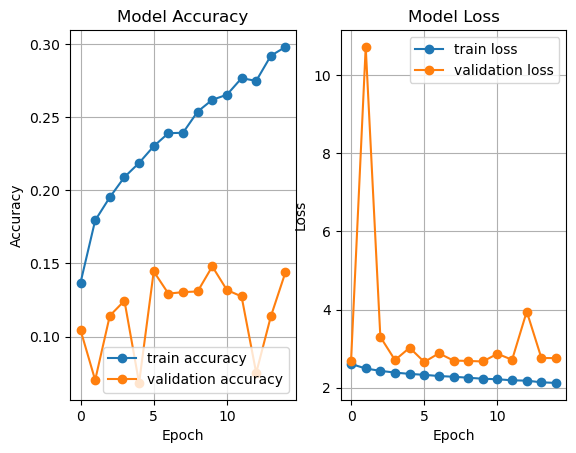

In [62]:
# Plot training & validation accuracy values
plt.subplot(1,2,1)
plt.plot(history_1.history['accuracy'], 'o-', label='train accuracy')
plt.plot(history_1.history['val_accuracy'], 'o-', label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history_1.history['loss'], 'o-', label='train loss')
plt.plot(history_1.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [41]:
import seaborn as sns


ModuleNotFoundError: No module named 'seaborn'

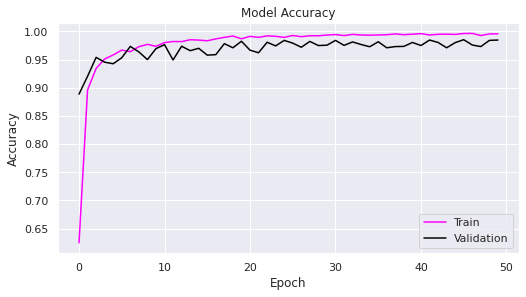

In [ ]:
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(history_1.history['accuracy'], color="Magenta")
plt.plot(history_1.history['val_accuracy'] , color="Black")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
plt.savefig('/home/nazia/Desktop/Research/Compound/Graph/CompoundDenseAdamAccuracy.svg')



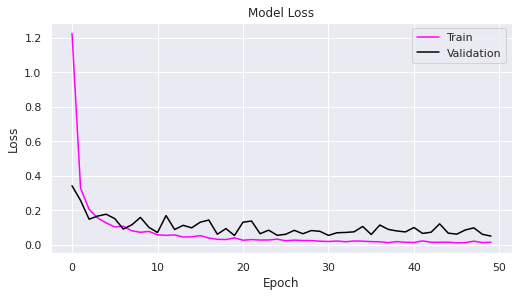

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(history_1.history['loss'], color="magenta")
plt.plot(history_1.history['val_loss'], color="Black")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
plt.savefig('/home/nazia/Desktop/Research/Compound/Graph/CompoundDenseAdamLoss.svg')
#plt.savefig('G:/Nazia/BanglaLekha/Comp-graph/Com_loss18.png')

In [44]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [47]:
Y_pred = model.predict(validation_generator, num_validation_samples// batch_size)
print(Y_pred.shape)
y_pred = np.argmax(Y_pred, axis=1)
y_true= validation_generator.classes

target_names = ['62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76' ]
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

79/79 [==============================] - 17s 212ms/step
(1580, 15)
              precision    recall  f1-score   support

          62      0.180     0.162     0.171       111
          63      0.333     0.342     0.338       111
          64      0.255     0.108     0.152       111
          65      0.573     0.532     0.551       111
          66      0.230     0.153     0.184       111
          67      0.136     0.216     0.167       111
          68      0.027     0.259     0.049        27
          69      0.807     0.645     0.717       110
          70      0.091     0.027     0.042       111
          71      0.141     0.126     0.133       111
          72      0.183     0.117     0.143       111
          73      0.206     0.261     0.230       111
          74      0.095     0.036     0.052       111
          75      0.483     0.631     0.547       111
          76      0.149     0.117     0.131       111

    accuracy                          0.248      1580
   macro avg 

In [48]:
cm = confusion_matrix(y_true, y_pred)

In [50]:
classes=15

In [51]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.BuGn
                         ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1]), ):
        plt.text(j, i, cm[i, j, ],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    

In [52]:
import imp
imp.reload(sns)

C:\Users\Mohammad Sheakh\AppData\Local\Temp\ipykernel_9592\31953510.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


NameError: name 'sns' is not defined

In [ ]:
sns.reset_defaults()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties

# plt.figure() 
# prop = FontProperties()
# prop.set_file('Siyamrupali.ttf')

Confusion matrix, without normalization
[[131   0   0   1   0   0   0   0   0   0   0  14   0   0   0   0   0   0
    0   0   0   0   1   1]
 [  0 149   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   0   0   0]
 [  0   0 135   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 136   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0  10 119   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0 149   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 135   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 148   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   1 120   0   0   0   0   0   0   0   0   0
    2   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0   0 131   0   0  

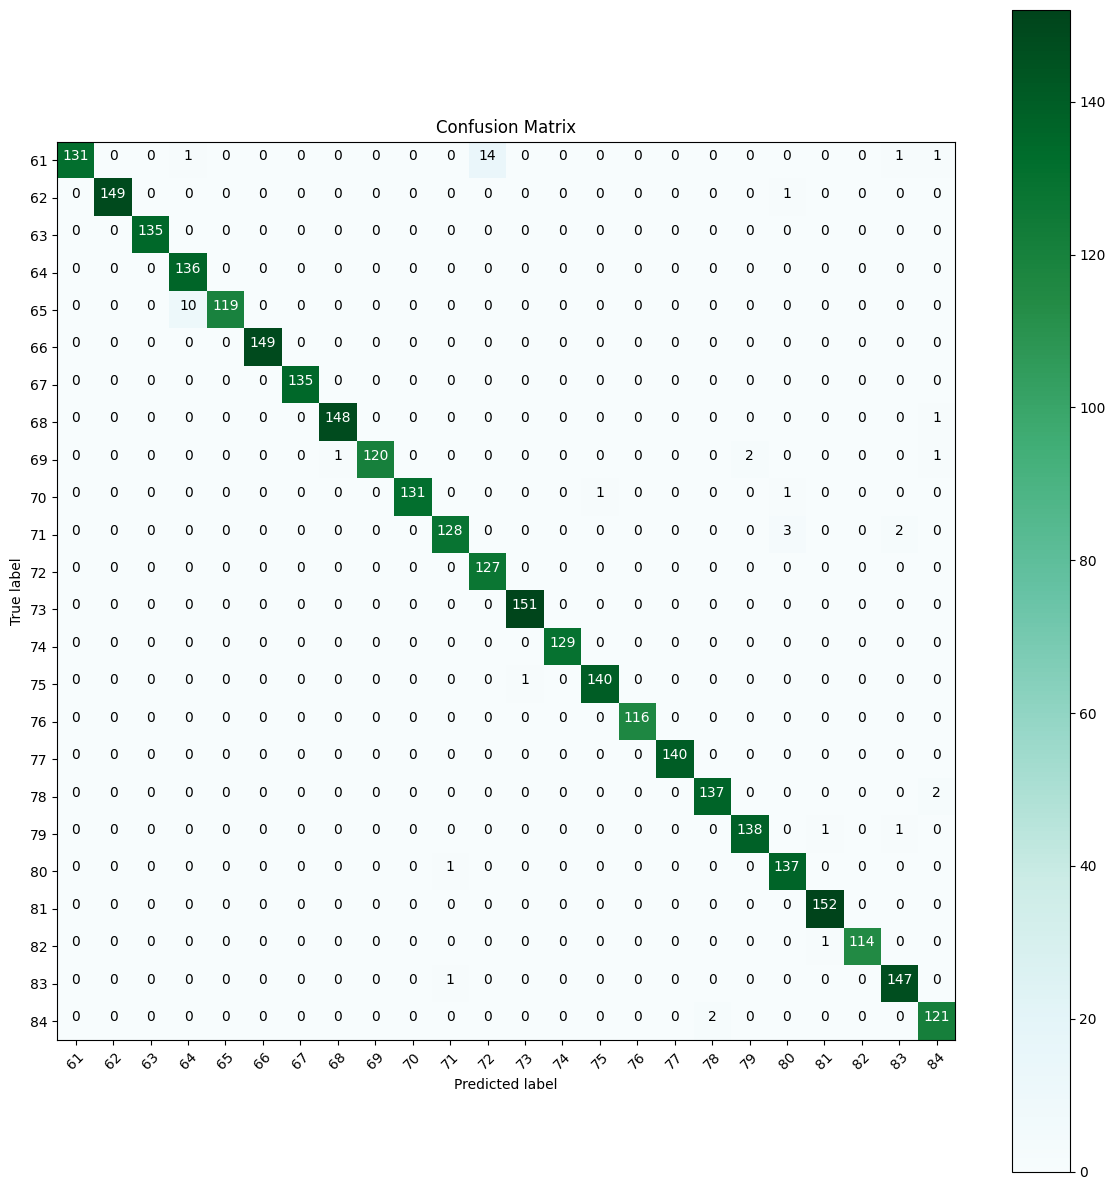

In [ ]:
cm_plot_labels = ['61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81','82','83','84']
#sns.set_theme()
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
plt.savefig('/home/nazia/Desktop/Research/Compound/Graph/CompoundAdamDenseNetCF.svg')
#plt.savefig('G:/Nazia/BanglaLekha/Comp-graph/cf_val_git_05.png')